# Assignment 6

**Submission deadline:**

* **Problem 1 is due last lab session before or on Wednesday, 31.01.18**

* **Bonus problems are due Wednesday, 7.02.18**

Lecture on SVM (necessary for solving bonus problems 4-7) will take place on Saturday, 27.01.2018 from 10am - 2pm in room 119.

**Points: 4 + 11 bonus points**


## Downloading this notebook

This assignment is an Jupyter notebook. Download it by cloning https://github.com/janchorowski/nn_assignments. Follow the instructions in its README for instructions.

Please do not hesitate to use GitHub’s pull requests to send us corrections!

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Problem 2: K-Means [2p bonus]

Fill in the blanks in the K-means code. Then compare the following 3 strategies for initial point selection

1. Uniform sampling over the range of the data
2. Uniform sampling of data points
3. Kmeans++ (http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf, pg. 3):
    1. the first point is sampled uniformly from the dataset
    2. subsequent points are sampled with probability $\frac{D(x)^2}{\sum_{x'} D(x')^2}$, where $D(x)$ denotes the distance from $x$ to a nearest point that was already chosen. 
    
Conduct experiments for various number of clusters and different initialization strategies. Make screenshots of some representative solutions (and failure modes).

Make one cluster of the generated data much 3-5 times larger. How does it affect the K-means solution?

(2, 160)

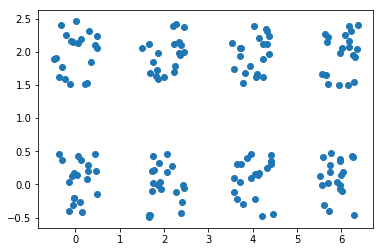

In [2]:
def gen_cluster(x0, y0, n=20):
    return np.random.rand(2,n) + np.array([[x0],[y0]]) - 0.5

def gen_data():
    clusters = []
    for x in [0,2,4,6]:
        for y in [0,2]:
            n = 20
            clusters.append(gen_cluster(x,y,n))
    return np.hstack(clusters)

data = gen_data()
scatter(data[0,:], data[1,:])
data.shape

In [3]:
def dist(X,Y):
    dd = X[:,None,:] - Y[:,:,None]
    dd = (dd**2).sum(0)
    return dd

In [4]:
def k_means(data, k=2, init_pts='rand_samples'):
    dim, ns = data.shape
    
    if init_pts == 'rand_samples':
        C = data[:,np.random.choice(ns, k, replace=False)]
    elif init_pts == 'rand_range':
        mins = data.min(axis=1)
        maxs = data.max(axis=1)
        intervals = maxs-mins
        C = np.transpose(np.random.rand(k,dim)*intervals+mins)
    elif init_pts == 'km++':
        C = np.zeros((dim, k))
        pbb = np.ones(ns)/ns
        for center in range(k):
            next_center = np.random.choice(ns, 1, replace=False, p=pbb)
            C[:,center] = data[:,next_center].flatten()
            min_sq_distances = dist(data, C[:,:center+1]).min(axis=0)**2
            dist_sum = min_sq_distances.sum()
            pbb = min_sq_distances/dist_sum
        #C = np.array([[0.,0.,2.,2.,4.,4.,6.,6.],[0.,2.,0.,2.,0.,2.,0.,2.]])
    else:
        raise Exception('invalid init_pts!')
    
    Cinit = C.copy()
    last_assignments = np.zeros((ns,))
    while True:
        D = dist(data, C)
        assignment = np.argmin(D, axis=0)

        for ci in xrange(k):
            sel = assignment==ci
            if sum(sel) == 0:
                print 'empty cluster: ', ci, '!'
                C[:,ci] = np.inf
            else:
                C[:,ci] = data[:,sel].mean(axis=1)
        if np.all(assignment == last_assignments):
            break
        last_assignments = assignment

    return assignment, C, Cinit

[[ 6.04374845e+00 -6.67319582e-04  4.01991746e+00  2.21741131e-02
   5.98113758e+00  4.00926712e+00  1.99490764e+00  2.01933197e+00]
 [ 2.03789827e+00 -2.65293491e-02  2.02791394e-02  2.00508663e+00
  -5.29012458e-02  1.97686466e+00  3.61859281e-02  1.92418125e+00]]


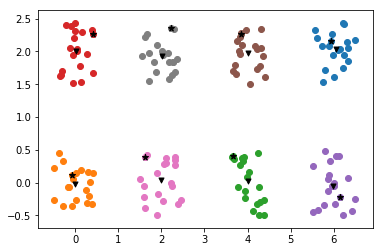

In [59]:
colormap = [
    (0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
    (1.0, 1.0, 0.7019607843137254),
    (0.7450980392156863, 0.7294117647058823, 0.8549019607843137),
    (0.984313725490196, 0.5019607843137255, 0.4470588235294118),
    (0.5019607843137255, 0.6941176470588235, 0.8274509803921568),
    (0.9921568627450981, 0.7058823529411765, 0.3843137254901961),
    (0.7019607843137254, 0.8705882352941177, 0.4117647058823529),
    (0.9882352941176471, 0.803921568627451, 0.8980392156862745)]


a, c, cinit = k_means(data, 8, init_pts='km++')
print(c)
for ci in set(a):
    scatter(data[0,a==ci],data[1,a==ci])#, color=colormap[ci], s=25)

scatter(cinit[0,:], cinit[1,:], color='k',marker='*', s=40)
scatter(c[0,:], c[1,:], color='k',marker='v', s=25)

# Problem 3: Bisecting K-Means [2p bonus]

Implement the "Bisecting k-means" algorithm, such as the one from Apache Spark: https://spark.apache.org/docs/1.6.0/api/java/org/apache/spark/mllib/clustering/BisectingKMeans.html.

In [ ]:
import collections

In [100]:
def bisect_kmeans(data, k, init_pts='km++', set_num=1):    
    if k==1:
        A, C, Cinit = k_means(data, 1, init_pts)
        A = A+set_num
    
    elif k>=2:
        new_data, Centr, Cinit = k_means(data, 2, init_pts)

        first_subset, second_subset =  collections.Counter(new_data).items()
        if first_subset[1] > second_subset[1]:
            bigger_data = data[:,new_data==first_subset[0]]
            smaller_data = data[:,new_data==second_subset[0]]
        else:
            smaller_data = data[:,new_data==first_subset[0]]
            bigger_data = data[:,new_data==second_subset[0]]
            
        biggerA, biggerC, biggerCinit = bisect_kmeans(bigger_data, math.ceil(k/2.0), init_pts, set_num*2)
        smallerA, smallerC, smallerCinit = bisect_kmeans(smaller_data, math.floor(k/2.0), init_pts, set_num*2+1)
            
        A = np.append(biggerA, smallerA, axis=0)
        C = np.append(biggerC, smallerC, axis=1)
        Cinit = np.append(biggerCinit, smallerCinit, axis=1)

    return A, C, Cinit 

(2, 160)

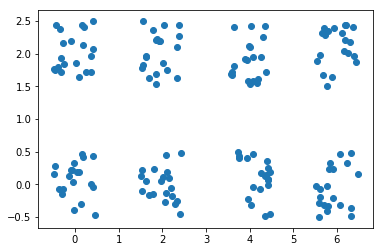

In [101]:
data = gen_data()
scatter(data[0,:], data[1,:])
data.shape

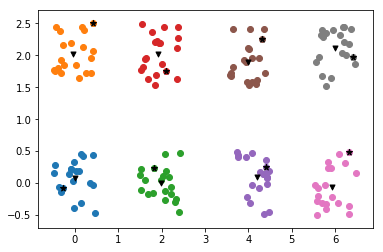

In [158]:
a, c, cinit = bisect_kmeans(data, 8, init_pts='km++')

for ci in set(a):
    scatter(data[0,a==ci],data[1,a==ci])

scatter(cinit[0,:], cinit[1,:], color='k',marker='*', s=40)
scatter(c[0,:], c[1,:], color='k',marker='v', s=25)